# Importing packages

In [92]:
import os
import zipfile
from datetime import datetime
from pathlib import Path
import numpy as np 
import pandas as pd
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
import requests
import openpyxl
import folium
import seaborn as sns
import geopandas as gpd

# Define recursive functions

In [93]:
def download_from_url(file_url,filepath):
    req = requests.get(file_url)
    with open(filepath, 'wb') as file:
        file.write(req.content)
    
    
def download_zip_url(file_url,filedest):
    req = requests.get(file_url)
    zipped = zipfile.ZipFile(io.BytesIO(req.content))
    zipped.extractall(filedest)

# Import files

In [94]:
dirname = 'Data'

In [95]:
if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(dirname):
        try:
            os.mkdir(dirname)
        except OSError:
            print ("Creation of the directory %s failed" % dirname)
        else:
            print ("Successfully created the directory %s " % dirname)
    else: 
        print ("Directory %s already exists" % dirname)

Directory Data already exists


## Downloading the required datasets for the analysis 

In [96]:
filename = 'postcodes.csv'

if os.path.isfile(dirname+'/'+filename):
    print ("File %s already exists" % filename)
else:
    download_zip_url('https://www.doogal.co.uk/files/postcodes.zip',dirname)
    print ("Successfully downloaded the file %s " % filename)

File postcodes.csv already exists


In [97]:
#Linking the required datasets with the URLs to download them from 

required_files = {'EIR_E0019012.xlsx':'https://storage.googleapis.com/na_evhs/EIR_E0019012.xlsx',
                 'electric-vehicle-charging-device-statistics-october-2020.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/933589/electric-vehicle-charging-device-statistics-october-2020.ods',
                 'veh0132.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942248/veh0132.ods',
                 'veh0134.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942250/veh0134.ods',
                 'veh0122.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942242/veh0122.ods'}

In [98]:
# If not already present inside "Data" folder, download the required datasets and
# check the last time the datasets where downloaded/modified

for filename in required_files.keys():
    
    file_path = dirname+'/'+filename
    
    if os.path.isfile(file_path):
        print ("File %s already exists" % filename)
    else:
        download_from_url(required_files[filename],file_path)
        print ("Successfully downloaded the file %s " % filename)
    
    try:
        mtime = os.path.getmtime(file_path)
    except OSError:
        mtime = 0
    last_modified_date = datetime.fromtimestamp(mtime)
    
    print('    Last modified '+last_modified_date.strftime("%d/%m/%Y %H:%M:%S"))

File EIR_E0019012.xlsx already exists
    Last modified 12/01/2021 09:58:11
File electric-vehicle-charging-device-statistics-october-2020.ods already exists
    Last modified 12/01/2021 09:58:11
File veh0132.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0134.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0122.ods already exists
    Last modified 08/01/2021 10:50:22


In [99]:
#For file containing multiple sheets (e.g. Excel spreadsheet files) determine the number and the name of each sheet

for filename in os.listdir(dirname):
    
    file_path = dirname+'/'+filename
    
    if filename.endswith('.ods') or filename.endswith('.xls'):
        
        file_preview = pd.ExcelFile(file_path, engine ='odf')
        sheets_number = [sheet for sheet in file_preview.sheet_names if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
        
    elif filename.endswith('.xlsx'):
        
        file_preview = openpyxl.load_workbook(file_path) 
        sheets_number = [sheet for sheet in file_preview.sheetnames if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
    
    

EIR_E0019012.xlsx has 1 sheet(s): ['bypostcodedistrict']
electric-vehicle-charging-device-statistics-october-2020.ods has 3 sheet(s): ['Info', 'EVCD_01', 'EVCD_02']
veh0122.ods has 11 sheet(s): ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
veh0132.ods has 4 sheet(s): ['VEH0132a', 'VEH0132b', 'VEH0132c', 'VEH0132d']
veh0134.ods has 3 sheet(s): ['VEH0134a', 'VEH0134b', 'VEH0134c']


# Import Postcode data

In [100]:
#Import file containing the information about, among others, postcodes, local authority, constituency and population
postcode = pd.read_csv(dirname+'/postcodes.csv') 

C:\Users\andre\.conda\envs\na2021\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [101]:
postcode.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area'],
      dtype='object')

In [102]:
postcode.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income,Sewage Company,Travel To Work Area
0,AB1 0AA,No,57.101474,-2.242851,385386.0,801193.0,NJ853011,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.31408,AB,AB1,Scotland,Scottish Water,9C9V4Q24+HV,NaN,NaN,Aberdeen
1,AB1 0AB,No,57.102554,-2.246308,385177.0,801314.0,NJ851013,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.55457,AB,AB1,Scotland,Scottish Water,9C9V4Q33+2F,NaN,NaN,Aberdeen
2,AB1 0AD,No,57.100556,-2.248342,385053.0,801092.0,NJ850010,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.54352,AB,AB1,Scotland,Scottish Water,9C9V4Q22+6M,NaN,NaN,Aberdeen
3,AB1 0AE,No,57.084444,-2.255708,384600.0,799300.0,NO845992,NaN,Aberdeenshire,North Kincardine,...,Portlethen,8.20809,AB,AB1,Scotland,Scottish Water,9C9V3PMV+QP,NaN,NaN,Aberdeen
4,AB1 0AF,No,57.096656,-2.258102,384460.0,800660.0,NJ844006,NaN,Aberdeen City,Lower Deeside,...,Portlethen,8.85583,AB,AB1,Scotland,Scottish Water,9C9V3PWR+MQ,NaN,NaN,Aberdeen


In [103]:
#Removing unnecessary columns to reduce the size and, therefore, the computational power required to process the dataframe
postcode = postcode.drop(['Grid Ref','County','Introduced', 'Terminated',
       'Parish', 'National Park','Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area'], axis = 1)

In [104]:
#Selecting only the postcodes that are still in use
postcode_sel = postcode.loc[postcode['In Use?']=='Yes']

In [105]:
postcode_sel.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code,Postcode area,Postcode district
2656,AB10 1AB,Yes,57.149606,-2.096916,394235.0,806529.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2658,AB10 1AF,Yes,57.148707,-2.097806,394181.0,806429.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2659,AB10 1AG,Yes,57.149051,-2.097004,394230.0,806467.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2660,AB10 1AH,Yes,57.148080,-2.094664,394371.0,806359.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2662,AB10 1AL,Yes,57.150058,-2.095916,394296.0,806579.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10


In [106]:
#Calculate the percentage of missing data in the dataframe

print('Missing {per:.2f}% of Postcode data'.format(per = postcode_sel['Postcode'].isnull().values.sum()/len(postcode_sel)*100)) 
print('Missing {per:.2f}% of District data'.format(per =postcode_sel['District'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Constituency data'.format(per =postcode_sel['Constituency'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Population data'.format(per =postcode_sel['Population'].isnull().values.sum()/len(postcode_sel)*100))

Missing 0.00% of Postcode data
Missing 0.08% of District data
Missing 0.08% of Constituency data
Missing 15.62% of Population data


In [107]:
#Replace NaN values in the population column with zeros
postcode_sel['Population'].fillna(0)

2656        0.0
2658        0.0
2659        0.0
2660        0.0
2662        0.0
           ... 
2638414    46.0
2638415    27.0
2638416    28.0
2638417    23.0
2638418    56.0
Name: Population, Length: 1760653, dtype: float64

In [108]:
postcode_sel.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code,Postcode area,Postcode district
2656,AB10 1AB,Yes,57.149606,-2.096916,394235.0,806529.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2658,AB10 1AF,Yes,57.148707,-2.097806,394181.0,806429.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2659,AB10 1AG,Yes,57.149051,-2.097004,394230.0,806467.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2660,AB10 1AH,Yes,57.148080,-2.094664,394371.0,806359.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001,AB,AB10
2662,AB10 1AL,Yes,57.150058,-2.095916,394296.0,806579.0,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001,AB,AB10


In [114]:
postcode_district_number = len(postcode_sel['Postcode district'].unique())

In [115]:
#Calculate what is the percentage difference between the total UK population calculated using the data
#from the postcode_sel DataFrame and the actual value

population_sum = postcode_sel['Population'].sum()
uk_population = 66.65*10**6

print( 'Percentage difference in population {per:.2f} %'.format( per = abs(population_sum-uk_population)/uk_population*100 ))

Percentage difference in population 5.44 %


The realatively small difference between the values allows to categorise the missing information about the population as negligile overall. This, however, can still have a significant impact locally.\
 \
NOTE: The reason for this difference resides in the old nature of the postcode.csv file (released in 2019 and not uploaded ever since)

In [116]:
#Create a list containing the name of the District associated with the postcodes. 
#These should correspond to the local authority names in the 'electric-vehicle-charging-device-statistics-october-2020' file. 

district = postcode_sel['District'].unique().tolist()

In [117]:
#Remove any non string value from the district list
for item in district: 
    if not isinstance(item,str):
        district.remove(item)

In [118]:
#Create a list containing the code associated with each Local Authority. 
#These should correspond to the ones in the 'electric-vehicle-charging-device-statistics-october-2020' file. 

district_code = postcode_sel['District Code'].unique().tolist()

In [119]:
#Remove any non string value from the district list
for item in district_code: 
    if not isinstance(item,str):
        district_code.remove(item)

In [120]:
#Create a dictionary to associate each local authority with the corresponding ONS code area
dic_la = {item:code for item,code in zip(district,district_code)}

In [318]:
dic_code = {code:item for code,item in zip(district_code,district)}

In [121]:
#Create a list containing the name of the 650 UK constituencies. 

constituency = postcode_sel['Constituency'].unique().tolist() 

In [122]:
#Remove any non string value from the constituency list
for item in constituency: 
    if not isinstance(item,str):
        constituency.remove(item)

In [123]:
#Create a dictionary to associate each constituency with the corresponding population

dic_population = {item:int(postcode_sel.loc[postcode_sel['Constituency']==item]['Population'].sum()) for item in constituency}

In [124]:
#Create a dictionary to associate each constituency with the corresponding postcodes

dic_constituency = {item:'' for item in constituency}
for item in constituency: 
    list_val = postcode_sel.loc[postcode_sel['Constituency']==item]['Postcode'].values
    list_val_sel=[]
    for val in list_val:
        lval = val.split(' ')[0]
        if lval not in list_val_sel:
            list_val_sel.append(lval)
    dic_constituency[item] = list_val_sel

In [125]:
#Create a dictionary to associate each Local Authority with the corresponding postcodes

dic_district = {item:'' for item in district}
for item in district: 
    list_val = postcode_sel.loc[postcode_sel['District']==item]['Postcode'].values
    list_val_sel=[]
    for val in list_val:
        lval = val.split(' ')[0]
        if lval not in list_val_sel:
            list_val_sel.append(lval)
    dic_district[item] = list_val_sel

In [126]:
#Create a dictionary to associate each Local Authority with the corresponding population

dic_dist_population = {item:int(postcode_sel.loc[postcode_sel['District']==item]['Population'].sum()) for item in district}

In [127]:
#Create a dictionary to associate each constituency with the corresponding local authority

dic_constituency_district = {item:'' for item in constituency}
for item in constituency: 
    list_val = postcode_sel.loc[postcode_sel['Constituency']==item]['District'].values
    list_val_sel=[]
    for val in list_val:
        if val not in list_val_sel:
            list_val_sel.append(val)
    dic_constituency_district[item] = list_val_sel

# Import public charging devices data

## Charging devices per local authority

In [148]:
dft_charging_devices_available_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_01', headers=False)
dft_charging_devices_available_import = dft_charging_devices_available_import[dft_charging_devices_available_import.iloc[:,1].notnull()]

dft_charging_devices_available = dft_charging_devices_available_import.iloc[1:]
dft_charging_devices_available.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_available.columns = dft_charging_devices_available_import.iloc[0]

In [173]:
dft_charging_devices_available.head()

6,LA / Region Code,Local Authority / Region Name,Total public\ncharging devices,Total public rapid\ncharging devices,"Charging devices per\n100,000 population","Rapid Devices per\n100,000 population"
0,K02000001,UNITED KINGDOM,19487.0,3530.0,29.173550,5.284684
1,K03000001,GREAT BRITAIN,19169.0,3508.0,29.534781,5.404977
2,E92000001,ENGLAND,16456.0,2909.0,29.235901,5.168160
3,E12000001,NORTH EAST,849.0,156.0,31.798455,5.842826
4,E06000047,County Durham,106.0,15.0,19.996453,2.829687


In [174]:
print('Missing {per:.2f}% of entire data'.format(per = dft_charging_devices_available.isnull().values.sum()/len(dft_charging_devices_available)*100)) 

Missing 0.00% of entire data


In [175]:
dft_charging_devices_available = dft_charging_devices_available.dropna() #Removing rows containing NaN values 

In [176]:
len(dft_charging_devices_available)

427

In [177]:
#data_try = dft_charging_devices_available[dft_charging_devices_available['LA / Region Code'].isin(district_code)]

## Total charging devices per quarter since Q1 2015

In [191]:
dft_charging_devices_quarter_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_02', headers=False) 
dft_charging_devices_quarter_import = dft_charging_devices_quarter_import[dft_charging_devices_quarter_import.iloc[:,1].notnull()]

dft_charging_devices_quarter = dft_charging_devices_quarter_import.iloc[1:]
dft_charging_devices_quarter.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_quarter.columns = dft_charging_devices_quarter_import.iloc[0]
dft_charging_devices_quarter = dft_charging_devices_quarter.fillna(method='ffill')
dft_charging_devices_quarter = dft_charging_devices_quarter.dropna(axis =1)
dft_charging_devices_quarter.head()

6,Year,Quarter,Total Devices,Rapid Devices
0,2015.0,Q1,2664.0,249.0
1,2015.0,Q2,2910.0,301.0
2,2015.0,Q3,3248.0,431.0
3,2015.0,Q4,3672.0,693.0
4,2016.0,Q1,3916.0,781.0


In [190]:
dft_charging_devices_quarter.tail()

6,Year,Quarter,Total Devices,Rapid Devices
18,2019.0,Q3,15116.0,2495.0
19,2019.0,Q4,16505.0,2829.0
20,2020.0,Q1,17947.0,3107.0
21,2020.0,Q2,18265.0,3206.0
22,2020.0,Q3,19487.0,3530.0


In [194]:
df_charges_quarter = pd.DataFrame(dft_charging_devices_quarter['Total  Devices'])
df_charges_quarter['Time'] = [str(j)+' Q'+str(i)  for j in range(2015,2021) for i in range(1,5)][:-1]
df_charges_quarter =  df_charges_quarter.set_index('Time')

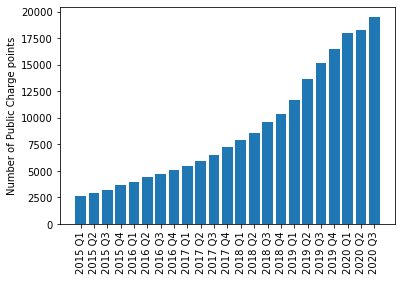

In [195]:
## Plot the trend of the publicly available charging devices in the UK between Q1 2015 and Q3 2020 ##

plt.bar(df_charges_quarter.index,df_charges_quarter['Total  Devices'],.8)
plt.xticks(rotation = 90)
plt.ylabel('Number of Public Charge points')
plt.show()

# Import ULEVs data by postcode district

In [197]:
#Import Ultra Low Emission Vehicles (ULEVs) table
dft_ulev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134a')
dft_ulev = dft_ulev_import[6:-14]
dft_ulev.columns = dft_ulev_import.iloc[5].values
dft_ulev.reset_index(inplace=True, drop=True)

In [198]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_ulev[dft_ulev['2020 Q3']=='c'])/len(dft_ulev)*100) )

Missing 0.27% of entire data


In [199]:
dft_ulev = dft_ulev.replace({'c':0}) # Replace the c values with zeros so that the statistics is not altered 

In [200]:
#Import Battery Electric Vehicles (BEVs) table by postcode
dft_bev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134b')
dft_bev = dft_bev_import[6:-14]
dft_bev.columns = dft_bev_import.iloc[5].values
dft_bev.reset_index(inplace=True, drop=True)

In [201]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_bev[dft_bev['2020 Q3']=='c'])/len(dft_bev)*100))

Missing 2.43% of entire data


In [202]:
dft_bev = dft_bev.replace({'c':0})

In [203]:
dft_bev.head()

,Postcode District 2,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,2019 Q2,2019 Q1,2018 Q4,2018 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
0,AB10,27.0,20.0,24.0,19.0,18.0,17.0,17.0,14.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AB11,28.0,24.0,21.0,21.0,19.0,18.0,17.0,15.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AB12,68.0,52.0,58.0,45.0,41.0,36.0,32.0,29.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AB13,10.0,9.0,11.0,11.0,10.0,9.0,9.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AB14,15.0,10.0,10.0,10.0,9.0,7.0,7.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
dft_bev_nhb = dft_bev.set_index('Postcode District 2')

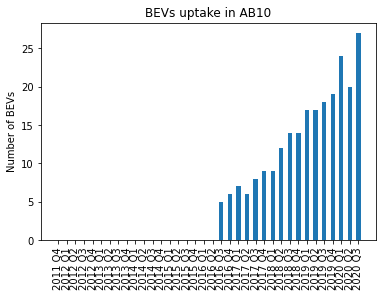

In [205]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs uptake

nhb_val = 'AB10'
nhb_sel = dft_bev_nhb.loc[nhb_val].reindex(index=dft_bev_nhb.loc[nhb_val].index[::-1])
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+nhb_val)
plt.show() 

In [206]:
#Import Plug-in Hybrid Electric Vehicles (PHEVs) data
dft_phev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134c')
dft_phev = dft_phev_import[6:-14]
dft_phev.columns = dft_phev_import.iloc[5].values
dft_phev.reset_index(inplace=True, drop=True)

In [207]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_phev[dft_phev['2020 Q3']=='c'])/len(dft_phev)*100))

Missing 4.56% of entire data


In [208]:
dft_phev = dft_phev.replace({'c':0})

# Import ULEVs data by local authority

In [209]:
#Import Battery Electric Vehicles (BEVs) table by LA
dft_bev_la_import = read_ods(dirname+'/veh0132.ods', 'VEH0132b')
dft_bev_la = dft_bev_la_import[6:-14]
dft_bev_la.columns = dft_bev_la_import.iloc[5].values
dft_bev_la.reset_index(inplace=True, drop=True)

In [210]:
dft_bev_la_sel = dft_bev_la[dft_bev_la['ONS LA Code'].isin(district_code)]
dft_bev_la_sel = dft_bev_la_sel.drop(['Region/Local Authority'],axis = 1).set_index(['ONS LA Code'])
dft_bev_la_sel = dft_bev_la_sel.replace({'c':0})

In [211]:
print('Missing {per:.2f}% of entire data'.format(per = 100-(len(dft_bev_la_sel))/len(district_code)*100))

Missing 2.11% of entire data


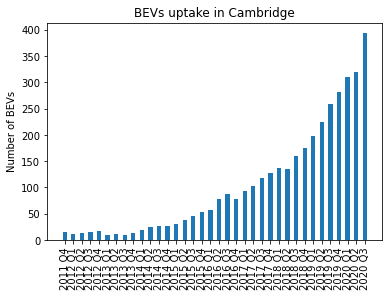

In [213]:
##Plot the Local Authority level of BEVs uptake

la_val = 'Cambridge'
la_sel = dft_bev_la_sel.loc[dic_la[la_val]].reindex(index=dft_bev_la_sel.loc[dic_la[la_val]].index[::-1])
plt.bar(la_sel.index,la_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+la_val)
plt.show() 

In [214]:
dft_bev_all = pd.DataFrame(dft_bev_la.iloc[0][2:])
dft_bev_all = dft_bev_all.reindex(index=dft_bev_all.index[::-1]) # Sort the index (Time) in ascending order 
dft_bev_all.index.names =['Time']
dft_bev_all.columns =['Total BEVs']

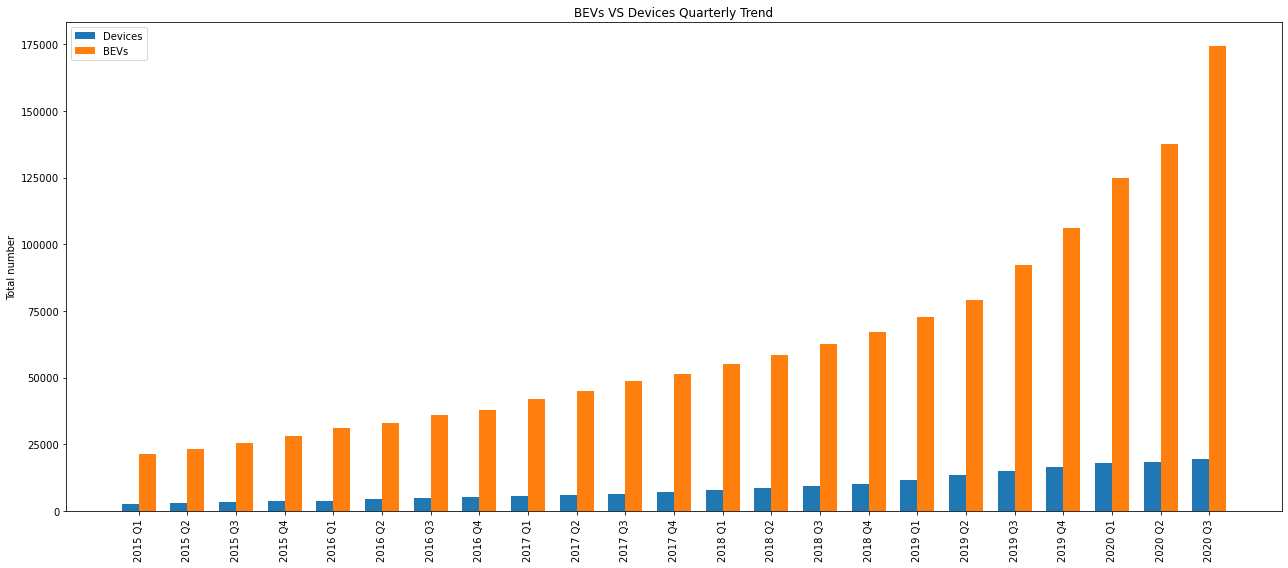

In [364]:
df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

x = np.arange(len(df_charges_bev.index))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x - width/2, df_charges_bev['Total  Devices'], width, label='Devices')
rects2 = ax.bar(x + width/2, df_charges_bev['Total BEVs'], width, label='BEVs')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total number')
ax.set_title('BEVs VS Devices Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)
ax.legend()

fig.tight_layout()

plt.show()
#fig.savefig('Devices_BEVs_comparision.png', bbox_inches='tight', dpi = 300)

# Import ALL vehicles data by postcode district

In [216]:
sheet_index = sorted(['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011'])

In [218]:
df = []

for idx in sheet_index:
    dft_all_import = read_ods(dirname+'/veh0122.ods', idx)
    dft_all_import = dft_all_import[dft_all_import.iloc[:,1].notnull()]
    dft_all = dft_all_import[2:]
    dft_all.columns = dft_all_import.iloc[1].values
    dft_all = dft_all.set_index('Postcode District')
    dft_all_sel = dft_all['Cars']
    dft_all_sel.columns = [idx +' Q'+str(i+1) for i in range(len(dft_all_sel.columns))]
    df.append(dft_all_sel)

In [219]:
dft_all_merged = pd.concat(df, axis =1,join='inner')
dft_all_merged = dft_all_merged.iloc[:,3:]

In [224]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_all_merged[dft_all_merged['2020 Q3']=='c'])/len(dft_all_merged)*100))

Missing 0.32% of entire data


In [226]:
dft_all_merged =dft_all_merged.replace({'c':0})

In [227]:
df_intersect =[]
for item in dft_all_merged.index: 
    if item in dft_bev_nhb.index.tolist():
        df_intersect.append(item)

In [242]:
print('Missing {per:.2f}% of the entire postcode districts'.format(per = (1 -len(df_intersect)/postcode_district_number)*100))

Missing 15.04% of the entire postcode districts


In [243]:
dft_bev_nhb_sel = dft_bev_nhb[dft_bev_nhb.index.isin(df_intersect)]
dft_all_merged_sel = dft_all_merged[dft_all_merged.index.isin(df_intersect)]

In [244]:
dft_ratio = dft_bev_nhb_sel/dft_all_merged_sel*100

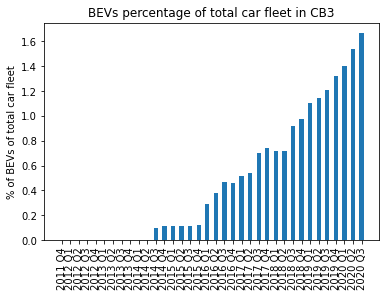

In [245]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs proportion to total car fleet

nhb_val = 'CB3'
nhb_sel = dft_ratio.loc[nhb_val]
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('% of BEVs of total car fleet')
plt.title('BEVs percentage of total car fleet in '+nhb_val)
plt.show() 

# Import private chargers data

In [247]:
fund_df_import = pd.read_excel(dirname+"/EIR_E0019012.xlsx")
fund_df_import = fund_df_import[fund_df_import.iloc[:,2].notnull()].dropna(axis =1)

fund_df = fund_df_import[1:]
fund_df.columns = fund_df_import.iloc[0].values
fund_df =fund_df.set_index('Postcode District')
fund_df.head()

,EVHS Grants,DRS Grants
Postcode District,,
AB1,0,0
AB10,17,…
AB11,…,0
AB12,59,…
AB13,19,…


In [250]:
# As stated in the file, all postcode districts with counts of at least one but fewer than ten have are indicated as "…".
#For statistical purpose, a lower estimate of this value is 1 and therefore "…" is replaced by the value 1. 
fund_df = fund_df.replace({'…':1})

# Create a DataFrame containing the necessary information per Local Authority



In [251]:
def private_or_public_charging(private_devices,electric_cars):
     if private_devices >= electric_cars: 
        return 'Predomintantly private'
     else: 
        return 'Predomintantly public'

In [256]:
columns_name = ['Local Authority','Total electric vehicles (BEVs)','Total public charging devices','Total public charging devices per 100,000 population','Total private charging devices','Charging devices usage']
summary_dataframe = pd.DataFrame({item:[] for item in columns_name})

for area in district:
    total_electric_vehicles = dft_bev_la[dft_bev_la['ONS LA Code']==dic_la[area]]['2020 Q3'].mean()
    public_charging_devices,public_charging_devices_density = dft_charging_devices_available[dft_charging_devices_available['LA / Region Code']==dic_la[area]][['Total public\ncharging devices','Charging devices per\n100,000 population']].mean()
    evhs_grant,drs_grant = fund_df[fund_df.index.isin(dic_district[district[0]])][['EVHS Grants','DRS Grants']].sum()
    
    
    total_public_charging_devices = int(public_charging_devices) 
    total_public_charging_devices_density = public_charging_devices_density
    total_private_charging_devices = int(evhs_grant + drs_grant)
    charging_devices_usage = private_or_public_charging(total_private_charging_devices, total_electric_vehicles)
    
    summary_dataframe = summary_dataframe.append(pd.DataFrame([[area,total_electric_vehicles,total_public_charging_devices,total_public_charging_devices_density,total_private_charging_devices,charging_devices_usage]], columns = columns_name))
    
summary_dataframe = summary_dataframe.set_index('Local Authority') # Set the Local Authority name as the DataFrame index

# Print the lookup table for each Local Authority

In [365]:
##Lookup table for each local authority number of EVs, public and private charging devices 
la_code = 'E06000047'

print('Summary for the '+dic_code[la_code]+' Local Authority:\n')
print(summary_dataframe.loc[la_name])

Summary for the County Durham Local Authority:

Total electric vehicles (BEVs)                                      459.000000
Total public charging devices                                       227.000000
Total public charging devices per 100,000 population                 78.037712
Total private charging devices                                      463.000000
Charging devices usage                                  Predomintantly private
Name: Brighton and Hove, dtype: object


# Identify Local Authorities where the commercial fleet is statistically significant

In [412]:
#Subselect for the dataframe the local authorities where there are more EVs than private chargers 
ratios = summary_dataframe['Total electric vehicles (BEVs)']/summary_dataframe['Total private charging devices']
old_ratios = len(ratios)

In [395]:
#Import ULEVs keepership table by LA
dft_keep_import = read_ods(dirname+'/veh0132.ods', 'VEH0132d')
dft_keep_import = dft_keep_import[dft_keep_import.iloc[:,1].notnull()]

dft_keep = dft_keep_import[1:]
dft_keep.columns = dft_keep_import.iloc[0]
dft_keep.reset_index(inplace=True, drop=True)
dft_keep.head()

5,ONS LA Code,Region/Local Authority,Private,Company
0,K02000001,United Kingdom,177147.0,190476.0
1,K03000001,Great Britain,175101.0,188336.0
2,E92000001,England,158025.0,175937.0
3,E12000001,North East,4093.0,1462.0
4,E06000047,County Durham UA,846.0,267.0


In [396]:
dft_keep_sel = dft_keep[dft_keep['ONS LA Code'].isin(district_code)]

In [397]:
#Select LAs for which the number of company ULEVs is twice the number of private ULEVs

outliers_code = dft_keep_sel[dft_keep_sel['Company'] > 2 *dft_keep_sel['Private']]['ONS LA Code'].tolist()
outliers_la = [dic_code[item] for item in outliers]

In [416]:
#Remove the previously identified LAs from the selected list rsel

ratios =ratios[~ratios.index.isin(outliers_la)]

print('{val} local authorities were removed from the list ({per:.2f}% of the data)'.format(val = old_ratios-len(ratios), per = (1-len(ratios)/old_ratios)*100 ))

ratios_sel=ratios_sel[ratios_sel!=np.inf]

print('{per:.2f}% of the data is infinity'.format(per = (1 -len(ratios_sel)/len(ratios))*100))

ratios_sel=ratios_sel.dropna()

print('{per:.2f}% of the data is NaN'.format(per = (1 - len(ratios_sel)/len(ratios))*100))
old_rsel = len(ratios_sel)

21 local authorities were removed from the list (5.54% of the data)
0.00% of the data is infinity
2.23% of the data is NaN


# Investigate top and bottom 10 Local authorities for public charger usage

In [417]:
ratios_gt_one = ratios_sel[ratios_sel >1]

print('{per:.2f}% of the local authorities have more BEVs than private chargers'.format(per = len(ratios_gt_one)/len(ratios)*100))

17.60% of the local authorities have more BEVs than private chargers


In [418]:
#Mean and median values for the BEVs/Private chargers > 1, respectively 
print(ratios_gt_one.mean())
print(ratios_gt_one.median())

1.6128424011793343
1.3736501079913608


In [419]:
#Standard Deviation values for the BEVs/Private chargers > 1
print(ratios_gt_one.std())

0.6488539580482435


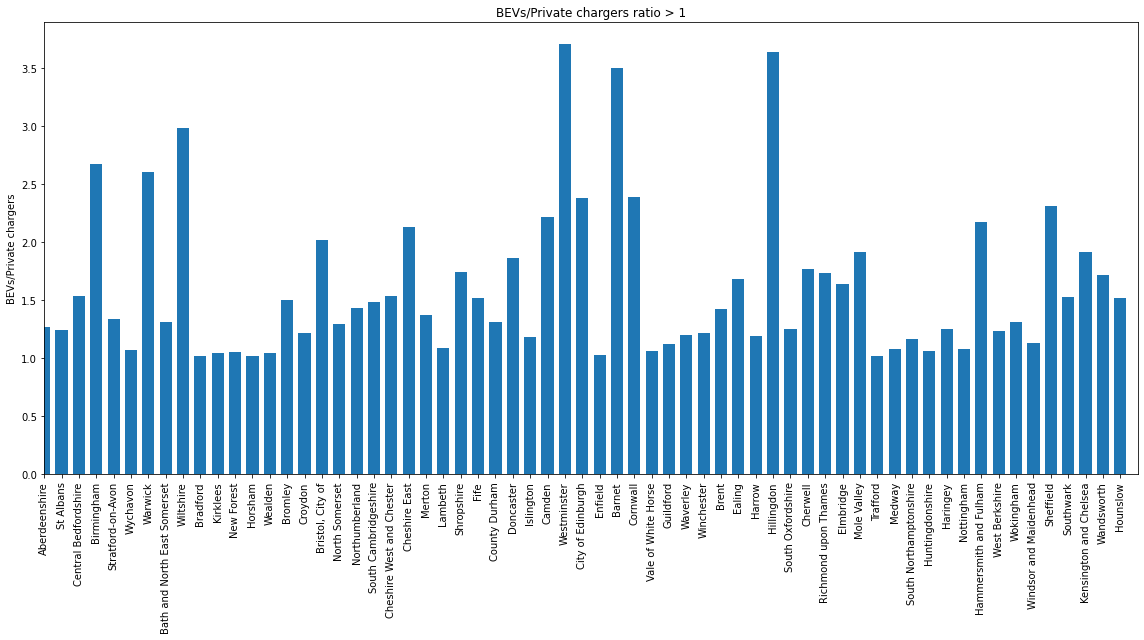

In [420]:
x = np.arange(len(ratios_gt_one))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x, ratios_gt_one, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/Private chargers')
ax.set_title('BEVs/Private chargers ratio > 1')
ax.set_xticks(x)
ax.set_xlim(0,len(ratios_gt_one))
ax.set_xticklabels(ratios_gt_one.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()

In [421]:
#Top 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values(ascending = False).head(10)

Local Authority
Westminster          3.710583
Hillingdon           3.643629
Barnet               3.505400
Wiltshire            2.984881
Birmingham           2.676026
Warwick              2.606911
Cornwall             2.388769
City of Edinburgh    2.384449
Sheffield            2.315335
Camden               2.222462
dtype: float64

In [422]:
#Bottom 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values().head(10)

Local Authority
Horsham                1.019438
Bradford               1.019438
Trafford               1.023758
Enfield                1.028078
Kirklees               1.047516
Wealden                1.049676
New Forest             1.053996
Huntingdonshire        1.062635
Vale of White Horse    1.062635
Wychavon               1.071274
dtype: float64

# Variation in BEVs uptake within a select few LAs

In [428]:
ratios_sel.sort_values(ascending=False).head(15)

Local Authority
Westminster               3.710583
Hillingdon                3.643629
Barnet                    3.505400
Wiltshire                 2.984881
Birmingham                2.676026
Warwick                   2.606911
Cornwall                  2.388769
City of Edinburgh         2.384449
Sheffield                 2.315335
Camden                    2.222462
Hammersmith and Fulham    2.172786
Cheshire East             2.136069
Bristol, City of          2.017279
Kensington and Chelsea    1.917927
Mole Valley               1.915767
dtype: float64

In [429]:
ratios_sel.sort_values(ascending=False)[170:180]

Local Authority
East Cambridgeshire    0.529158
North Tyneside         0.526998
Harborough             0.526998
Cheltenham             0.524838
Broadland              0.524838
Chorley                0.520518
Newham                 0.520518
Amber Valley           0.514039
Waltham Forest         0.511879
Lichfield              0.509719
dtype: float64

In [427]:
ratios_sel.sort_values(ascending=False).tail(15)

Local Authority
Oadby and Wigston      0.149028
Great Yarmouth         0.142549
Clackmannanshire       0.140389
Richmondshire          0.136069
Fermanagh and Omagh    0.136069
Gosport                0.131749
Middlesbrough          0.127430
Copeland               0.125270
Hyndburn               0.125270
Barrow-in-Furness      0.114471
Isles of Scilly        0.077754
Na h-Eileanan Siar     0.075594
Blaenau Gwent          0.071274
Shetland Islands       0.062635
Merthyr Tydfil         0.058315
dtype: float64

In [452]:
la_selection = ['Sheffield','East Cambridgeshire','Richmondshire']
df_selection =[]

for area in la_selection:
    df_selection.append(dft_bev_la_sel.loc[dic_la[area]].reindex(index=dft_bev_la_sel.loc[dic_la[area]].index[::-1]))

In [453]:
df_selection[0].index

Index(['2011 Q4', '2012 Q1', '2012 Q2', '2012 Q3', '2012 Q4', '2013 Q1',
       '2013 Q2', '2013 Q3', '2013 Q4', '2014 Q1', '2014 Q2', '2014 Q3',
       '2014 Q4', '2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4', '2016 Q1',
       '2016 Q2', '2016 Q3', '2016 Q4', '2017 Q1', '2017 Q2', '2017 Q3',
       '2017 Q4', '2018 Q1', '2018 Q2', '2018 Q3', '2018 Q4', '2019 Q1',
       '2019 Q2', '2019 Q3', '2019 Q4', '2020 Q1', '2020 Q2', '2020 Q3'],
      dtype='object')

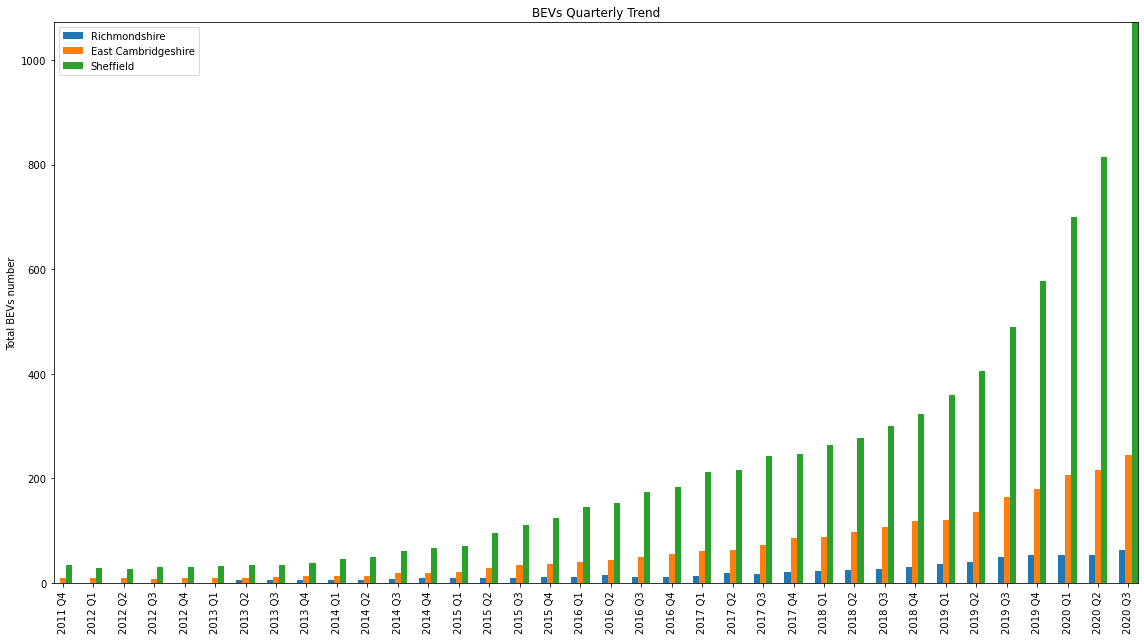

In [455]:
x = np.arange(len(df_selection[0].index))
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x -width, df_selection[2], width, label=la_selection[2])
rects2 = ax.bar(x, df_selection[1], width, label=la_selection[1])
rects3 = ax.bar(x + width,  df_selection[0], width, label=la_selection[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total BEVs number')
ax.set_title('BEVs Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_selection[0].index, rotation = 90)
ax.legend()
ax.autoscale(tight=True)

fig.tight_layout()

plt.show()

# Messing around with plots

In [142]:
la_geo = 'Data/LA_borders/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'

In [143]:
data_try.columns

Index(['LA / Region Code', 'Local Authority / Region Name',
       'Total public\ncharging devices',
       'Total public rapid\ncharging devices',
       'Charging devices per\n100,000 population',
       'Rapid Devices per\n100,000 population'],
      dtype='object')

In [547]:
import json
communities_geo = la_geo

# open the json file - json.load() methods returns a python dictionary
with open(communities_geo) as communities_file:
    communities_json = json.load(communities_file)
    
# we loop through the dictionary to obtain the name of the communities in the json file
denominations_json = []
for index in range(len(communities_json['features'])):
    denominations_json.append(communities_json['features'][index]['properties']['LAD20CD'])


In [548]:
communities_json['features'][index]['properties']

{'OBJECTID': 379,
 'LAD20CD': 'W06000024',
 'LAD20NM': 'Merthyr Tydfil',
 'LAD20NMW': 'Merthyr Tudful',
 'BNG_E': 305916,
 'BNG_N': 206424,
 'LONG': -3.36425,
 'LAT': 51.74858,
 'Shape__Area': 111930293.773514,
 'Shape__Length': 65314.3209843588}

In [148]:
data_try.columns

Index(['LA / Region Code', 'Local Authority / Region Name',
       'Total public\ncharging devices',
       'Total public rapid\ncharging devices',
       'Charging devices per\n100,000 population',
       'Rapid Devices per\n100,000 population'],
      dtype='object')

In [149]:
for item in denominations_json:
    if not item in data_try['LA / Region Code'].tolist():
        print(item)

In [150]:
sorted(data_try['LA / Region Code'].tolist())==denominations_json

True

In [197]:
# file name - file is located in the working directory
communities_geo = la_geo # geojson file

#  tiles = "cartodbpositron"
#communities_map = folium.Map(location=[40.416775, -3.703790], zoom_start=6, tiles='stamenwatercolor')
communities_map = folium.Map(location=[54.7, -4.6],
                    tiles = "cartodbpositron",
                    zoom_start = 5.4) 

In [198]:
# choropleth = folium.Choropleth(
#     name = 'charging_dev',
#     geo_data=communities_geo,
#     data=data_try,
#     columns=['LA / Region Code', 'Total public\ncharging devices', 'Charging devices per\n100,000 population'],
#     key_on='feature.properties.LAD20CD',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Total public charging devices',
#     smooth_factor=0).add_to(communities_map)

# style_function = "font-size: 15px; font-weight: bold"
# choropleth.geojson.add_child(
#     folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))

# folium.LayerControl().add_to(communities_map)

In [199]:
choropleth = folium.Choropleth(
    name = 'charging_dev',
    geo_data=communities_geo,
    data=data_try,
    columns=['LA / Region Code', 'Total public\ncharging devices', 'Charging devices per\n100,000 population'],
    key_on='feature.properties.LAD20CD',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Total public charging devices',
    smooth_factor=0).add_to(communities_map)
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))

choropleth = folium.Choropleth(
    name = 'charging_dens',
    geo_data=communities_geo,
    data=data_try,
    columns=['LA / Region Code', 'Charging devices per\n100,000 population'],
    key_on='feature.properties.LAD20CD',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Total charging devices per 100,000 population',
    smooth_factor=0).add_to(communities_map)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD20NM'], style=style_function, labels=False))
folium.LayerControl().add_to(communities_map)

# UPRNs

In [22]:
import shapely
import geopandas as gpd

In [2]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [3]:
lat_point_list = [50.854457, 52.518172, 50.072651, 48.853033, 50.854457]
lon_point_list = [4.377184, 13.407759, 14.435935, 2.349553, 4.377184]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

In [9]:
lat_point_list = [52.854457, 54.518172, 52.072651, 50.853033, 52.854457]
lon_point_list = [6.377184, 15.407759, 16.435935, 4.349553, 6.377184]

polygon_geom_2 = Polygon(zip(lon_point_list, lat_point_list))

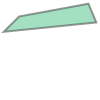

In [10]:
polygon_geom_2

In [11]:
point = Point(51.509865,-0.118092)

In [12]:
print(polygon_geom_2.contains(point))

False


In [88]:
a= [polygon_geom,polygon_geom_2]

In [20]:
df = pd.DataFrame([['AB1',polygon_geom],['AB2',polygon_geom_2]],columns = ['Partial Postcode','Coordinates
                                                                           
                                                                           
                                                                           '])

In [21]:
df

,Partial Postcode,Coordinates
0,AB1,"POLYGON ((4.377184 50.854457, 13.407759 52.518..."
1,AB2,"POLYGON ((6.377184 52.854457, 15.407759 54.518..."


In [26]:
crs = {'init': 'epsg:4326'}

In [81]:
gdf =gpd.GeoDataFrame(geometry = [polygon_geom], crs = crs)

In [82]:
gdf.geometry

0    POLYGON ((4.37718 50.85446, 13.40776 52.51817,...
Name: geometry, dtype: geometry

In [83]:
gdf = gdf.to_crs({'init': 'epsg:4326'})